In [19]:
import numpy as np
import pandas as pd
import sys, codecs
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import math
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from gensim.models.phrases import Phrases,Phraser
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import ast
import os    
import glob
import datetime
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [7]:
# load model well trained
frozen_model = Phraser.load('phrase_6g.pkl')
ngram_model=Word2Vec.load('ngram_onten.model')

In [3]:
idf=pd.read_csv('idf.csv')
SUM=pd.read_csv('tf6g.csv')

In [5]:
# pip install --upgrade gensim
import gensim
gensim.__version__

'3.8.3'

In [137]:
import mgwr

/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/utils.py:367: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if resetlist is not ():


In [2]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [3]:
df=pd.read_csv('UBDC/sale_2020/AB/sale_valid_property_id_expanded_year_2020_area_AB_part_00000.csv')

In [4]:
set(stopwords.words('english'))

SyntaxError: invalid syntax (3297653729.py, line 1)

In [10]:
test= api.load('word2vec-google-news-300')

In [11]:
test.save('word2vec-google-news-300')

In [22]:
import nltk
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# stopword tokenization lemmatization
# df.des_token=word_tokenize(df.description)
stopWords = [w.strip() for w in codecs.open('stopwords.txt', 'r').readlines()]
df['des_clea']=0
df['des_num']=0
df['des_clea']=df['des_clea'].astype('object')
for count in range(df.shape[0]):
    words=word_tokenize(df.loc[count,'description'])
#     stopWords = set(stopwords.words('english'))s
    # words = word_tokenize(data)
    wordsFiltered = []
    for w in words:
        w=porter_stemmer.stem(w)
        if w.lower() not in stopWords and len(w)>1 and not any(chr.isdigit()for chr in w):
            wordsFiltered.append(w.lower())
    df.at[count,'des_clea']=list(set(wordsFiltered))
    df.at[count,'des_num']=len(df['des_clea'][count]) #the number of clear tokens
    

In [14]:
# test
from textblob import Word
w = Word('agreeing')
print(w.lemmatize())

agreeing


In [4]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
print(wnl.lemmatize('went'),pos:'v')

SyntaxError: invalid syntax (2353639579.py, line 3)

In [55]:
# test
# import time
# start_time = time.time()
# for w in df['des_tf'][1]:
#     print(w)
print(wv.most_similar('tree', topn=10))


[('trees', 0.829312264919281), ('pine_tree', 0.7622087001800537), ('oak_tree', 0.731893002986908), ('evergreen_tree', 0.6926872730255127), ('fir_tree', 0.6917218565940857), ('willow_tree', 0.6845874786376953), ('pine_trees', 0.6824266910552979), ('maple_tree', 0.6803498864173889), ('sycamore_tree', 0.6681811809539795), ('tress', 0.6547872424125671)]


In [23]:
df_20word=df[df['des_num']>=20].copy()
df_20word=df_20word.reset_index()

In [27]:
def getWordVecs(wordList, model):
    name = []
    vecs = []
    for word in wordList:
#         word = word.replace('\n', '')
        try:
            if word in model:  # 模型中存在该词的向量表示
                name.append(word)
                vecs.append(model[word])
        except KeyError:
            continue
    a = pd.DataFrame(name, columns=['word'])
    b = pd.DataFrame(np.array(vecs, dtype='float'))
    return pd.concat([a, b], axis=1)

In [28]:
min=100000
df_20word['des_top']=0
df_20word['des_top']=df_20word['des_top'].astype('object')
for count in range(df_20word.shape[0]) :
    res=getWordVecs(df_20word.iloc[count]['des_clea'],wv)
    words = res["word"] # 词汇
    vecs = res.iloc[:,1:] # 向量表示
    kmeans = KMeans(n_clusters=1,random_state=10).fit(vecs)
    labels = kmeans.labels_ #类别结果标签
    labels = pd.DataFrame(labels,columns=['label'])
    new_df = pd.concat([labels,vecs],axis=1)
#     df_count_type = new_df.groupby('label').size() #各类别统计个数
#     if(df_count_type[0]<min):
#         min=df_count_type[0]
#         index=countx
#     print(df_count_type[0])
    # print df_count_type
    vec_center = kmeans.cluster_centers_ #聚类中心
    distances = []
    vec_words = np.array(vecs) # 候选关键词向量，dataFrame转array
    vec_center = vec_center[0] # 第一个类别聚类中心,本例只有一个类别
    length = len(vec_center) # 向量维度
    for index in range(len(vec_words)): # 候选关键词个数
        cur_wordvec = vec_words[index] # 当前词语的词向量
        dis = 0 # 向量距离
        for index2 in range(length):
            dis += (vec_center[index2]-cur_wordvec[index2])*(vec_center[index2]-cur_wordvec[index2])
        dis = math.sqrt(dis)
        distances.append(dis)
    distances = pd.DataFrame(distances,columns=['dis'])
    result = pd.concat([words, labels ,distances], axis=1) # 拼接词语与其对应中心点的距离
    result = result.sort_values(by="dis",ascending = True) # 按照距离大小进行升序排序
    wordlist = np.array(result['word']) # 选择词汇列并转成数组格式
    word_split = [wordlist[x] for x in range(0,10)] # 抽取前topK个词汇
#     print(word_split)
#     word_split = " ".join(word_split)
    df_20word.at[count,'des_top']=word_split
    

In [33]:
df_20word['des_top'][1]

['featur',
 'larg',
 'doubl',
 'acr',
 'veri',
 'gener',
 'front',
 'amd',
 'approximatley',
 'hous']

In [37]:
df_20word.to_csv('top10_lem_sale_valid_property_id_expanded_year_2020_area_AB_part_00000.csv',encoding="utf_8_sig")

In [57]:
df=pd.read_csv('top10_lem_sale_valid_property_id_expanded_year_2020_area_AB_part_00000.csv')

In [53]:
# df.columns
df.des_clea[1]

"['hallway', 'front', 'lend', 'bathroom', 'glazing.longhaven', 'land', 'acr', 'garden', 'bedroom', 'footbal', 'central', 'hob', 'patio', 'indivu', 'suite.th', 'detach', 'entri', 'enclosure.th', 'extractor', 'unit', 'fit', 'heat', 'includ', 'cruden', 'base', 'built', 'loung', 'flat', 'door', 'outbuild', 'amd', 'piec', 'tenni', 'separ', 'cours', 'approxim', 'featur', 'main', 'approximatley', 'aspect', 'park', 'oven', 'consist', 'window', 'downstair', 'spiral', 'extend', 'close', 'golf', 'laid', 'offic', 'util', 'sale', 'garag', 'doubl', 'oil', 'pitch', 'bay', 'larg', 'staircas', 'multitud', 'acres.th', 'hous', 'ground', 'school', 'lead', 'easili', 'ha', 'medic', 'kitchen', 'plot', 'court', 'shower', 'accomod', 'primari', 'adjac', 'modern', 'gener', 'wardrob', 'properti', 'thi', 'veri', 'room.complet', 'bathroom/show', 'fireplac', 'librari', 'floor', 'fire', 'surgeri', 'shop', 'sun', 'size', 'post', 'redeveloped.extern', 'wall']"

In [45]:
word = vectorizer.get_feature_names() 
# word
df_word =  pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

In [51]:
df_word.sum()

aarrow        1
ab           30
abbey        12
abderdeen     1
abelour       7
             ..
zoffani       2
zon           1
zonal         2
zone         54
zoopla        2
Length: 13643, dtype: int64

In [58]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.des_clea)
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)
word = vectorizer.get_feature_names()
weight = tfidf.toarray()

In [65]:
tfidf.getcol(0).toarray()[tfidf.getcol(0).toarray()>0]

array([0.14110048])

In [40]:
df['des_tf']=0
df['des_tf']=df['des_tf'].astype('object')
for i in range(len(weight)):
#         ids.append(idList[i])
#         titles.append(titleList[i])
        df_word,df_weight = [],[] # 当前文章的所有词汇列表、词汇对应权重列表
        for j in range(len(word)):
            df_word.append(word[j])
            df_weight.append(weight[i][j])
        df_word = pd.DataFrame(df_word,columns=['word'])
        df_weight = pd.DataFrame(df_weight,columns=['weight'])
        word_weight = pd.concat([df_word, df_weight], axis=1) # 拼接词汇列表和权重列表
        word_weight = word_weight.sort_values(by="weight",ascending = False) # 按照权重值降序排列
        keyword = np.array(word_weight['word']) # 选择词汇列并转成数组格式
        word_split = [keyword[x] for x in range(0,10)] # 抽取前topK个词汇作为关键词
        df.at[i,'des_tf']=word_split

In [41]:
df['des_tf']

0       [aberchird, bonu, bungalow, off, ad, oil, fire...
1       [amd, redeveloped, indivu, approximatley, long...
2       [vegetables, harlaw, toy, downsiz, beig, inde,...
3       [alarms, twoth, threethi, cellargood, balgowni...
4       [fail, around, order, tub, rur, wrap, instantl...
                              ...                        
9982    [glasgow, account, available, areainveruri, fa...
9983    [walled, millbank, spread, glaz, howev, modern...
9984    [shedno, investorsfantast, sh, kitchenutil, wo...
9985    [retire, approxclifton, clifton, downsiz, th, ...
9986    [oldmeldrum, burnsid, outwith, meldrum, avenu,...
Name: des_tf, Length: 9987, dtype: object

In [42]:
df.to_csv('vec_tf_lem_sale_valid_property_id_expanded_year_2020_area_AB_part_00000.csv',encoding="utf_8_sig")

In [9]:
ddf=dd.from_pandas(df,npartitions=10)
ddf

,listing_id,property_type,start_date,end_date,price_first,price_last,price_min,price_max,price_unique,price_flag,num_bed_first,num_bed_last,num_bed_min,num_bed_max,bed_flag,num_floors_min,num_floors_max,num_bath_min,num_bath_max,num_reception_min,num_reception_max,pcu,lon,lat,address,street_name,property_num,post_town,country,county,listing_status,epc_list,details_url,short_description,category,description,zdocument,branch_id,image_url,agent_logo,agent_name,agent_phone,agent_address,agent_postcode,image_caption,thumbnail_url,floor_plan,original_image,bullet,lad20nm
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,object,object,object,int64,int64,int64,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object
1000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
ddf.listing_id.unique().compute()

0       53172354
1       53055661
2       52712252
3       51669686
4       57423632
          ...   
3143    50444437
3144    58045040
3145    52628692
3146    57114212
3147    54718302
Name: listing_id, Length: 3148, dtype: int64

In [16]:
pip install "dask[distributed]" --upgrade

     |████████████████████████████████| 1.0 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 322 kB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 281 kB 12.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=2, memory_limit="1GB")
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:34385,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:46577,Total threads: 2
Dashboard: http://127.0.0.1:45735/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:45893,


# data clean

In [3]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.1.0/en_core_web_lg-3.1.0.tar.gz


     |████████████████████████████████| 777.1 MB 646 bytes/s a 0:00:01    |████▌                           | 109.8 MB 2.6 MB/s eta 0:04:19     |█████████▍                      | 227.1 MB 47.6 MB/s eta 0:00:12/s eta 0:00:13/s eta 0:00:32/s eta 0:00:32��▎               | 396.0 MB 12.4 MB/s eta 0:00:31��▌               | 400.2 MB 12.4 MB/s eta 0:00:31     |████████████████████████▎       | 588.5 MB 35.5 MB/s eta 0:00:06     |████████████████████████▌       | 594.2 MB 5.1 MB/s eta 0:00:36     |███████████████████████████     | 654.5 MB 30.5 MB/s eta 0:00:05     |███████████████████████████▋    | 671.8 MB 36.6 MB/s eta 0:00:03     |█████████████████████████████▋  | 718.2 MB 4.1 MB/s eta 0:00:15     |███████████████████████████████▌| 764.9 MB 31.2 MB/s eta 0:00:01     |███████████████████████████████▉| 774.4 MB 31.2 MB/s eta 0:00:01
  Created wheel for en-core-web-lg: filename=en_core_web_lg-3.1.0-py3-none-any.whl size=777079808 sha256=682815fb4beacc95216361d287297ebd6927b86c35b129b5ffbf9907

In [113]:
df=pd.read_csv('UBDC/sale_2020/AB/sale_valid_property_id_expanded_year_2020_area_AB_part_00000.csv')

In [4]:
import spacy
nlp = spacy.load('en_core_web_lg')


In [83]:
doc = nlp(df['description'].iloc[13])

In [12]:
# # document level
# ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
# print(ents)

# token level
ent_san = [doc[0].text, doc[0].ent_iob_, doc[0].ent_type_]
ent_francisco = [doc[1].text, doc[1].ent_iob_, doc[1].ent_type_]
print(ent_san)  # ['San', 'B', 'GPE']
print(ent_francisco)  # ['Francisco', 'I', 'GPE']

['Four', 'B', 'CARDINAL']
['bedroom', 'O', '']


In [37]:
%%time
wnl = WordNetLemmatizer()
# stopword tokenization lemmatization
# df.des_token=word_tokenize(df.description)
stopWords = [w.strip() for w in codecs.open('stopwords.txt', 'r').readlines()]
df['des_clea']=0
df['des_num']=0
df['des_clea']=df['des_clea'].astype('object')
for count in range(df.shape[0]):
    print(count/df.shape[0]*100,'%',end='\r')
    words=nlp(df['description'].iloc[count]) #token
#     words=word_tokenize(df.loc[count,'description'])  #原分词
#     stopWords = set(stopwords.words('english'))s
    wordsFiltered = []
    for w in words:
        if w.pos_=='VERB':
            wtext=wnl.lemmatize(w.text,pos='v')
        elif w.pos_=='ADJ':
            wtext=wnl.lemmatize(w.text,pos='a')
        else:
            wtext=wnl.lemmatize(w.text,pos='n')
        if wtext.lower() not in stopWords and len(wtext)>1 and not any(chr.isdigit()for chr in wtext):
            wordsFiltered.append(wtext.lower())
    df.at[count,'des_clea']=wordsFiltered
#     df.at[count,'des_clea']=list(set(wordsFiltered))   #set无重复
    df.at[count,'des_num']=len(df['des_clea'][count]) #the number of clear tokens
    

CPU times: user 10min 31s, sys: 2.13 s, total: 10min 33s
Wall time: 10min 29s


In [14]:
# produce_clean_token(filename,stopWords)的准备工作，优化性能
stopWords = [w.strip() for w in codecs.open('stopwords.txt', 'r').readlines()]

In [12]:
def produce_clean_token(filename,stopWords):
#     产生用于训练word2vec和n-gram的分词文件
#     v_num=0
#     n_num=0
#     a_num=0
    df=pd.read_csv(filename)
    wnl = WordNetLemmatizer()
    # whole process: stopword tokenization lemmatization
    # df.des_token=word_tokenize(df.description)
#     stopWords = [w.strip() for w in codecs.open('stopwords.txt', 'r').readlines()]
    df['des_clea']=0
#     df['des_num']=0
    df['des_clea']=df['des_clea'].astype('object')
    for count in range(df.shape[0]):
        wordsFiltered = []
        print(filename,'%.2f'%(count/df.shape[0]*100),'% current number:',count,'      ',end='\r')
#         print(filename, 'current number:',count,'      ',end='\r')
        if(pd.isnull(df['description'].iloc[count])):
            continue
        words=nlp(df['description'].iloc[count]) #token
#         words=word_tokenize(df.loc[count,'description'])  #原分词
    #     stopWords = set(stopwords.words('english'))s
        
        for w in words:
            if w.pos_=='NOUN':
                wtext=wnl.lemmatize(w.text,pos='n')
            elif w.pos_=='VERB':
                wtext=wnl.lemmatize(w.text,pos='v')
            elif w.pos_=='ADJ':
                wtext=wnl.lemmatize(w.text,pos='a')
            elif w.pos_=='NUM'or w.pos_=='PUNCT'or w.pos_=='SYM':
                continue
            else:
                wtext=wnl.lemmatize(w.text,pos='n')
            if wtext.lower() not in stopWords and len(wtext)>1 and not any(chr.isdigit()for chr in wtext):
                wordsFiltered.append(wtext.lower())
        df.at[count,'des_clea']=wordsFiltered
    #     df.at[count,'des_clea']=list(set(wordsFiltered))   #set无重复
#         df.at[count,'des_num']=len(df['des_clea'][count]) #the number of clear tokens
    df['des_clea'].to_csv(filename[0:-4]+'clean_token_complex.csv',encoding="utf_8_sig")
#     print('v:',v_num,'a:',a_num,'n:',n_num)


In [138]:
all(pd.isnull(df.description))

False

In [17]:
df[df['des_num']>100]['des_num'].describe()

count    8091.000000
mean      173.402175
std        60.676666
min       101.000000
25%       129.000000
50%       157.000000
75%       202.500000
max       632.000000
Name: des_num, dtype: float64

/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='des_num', ylabel='Density'>

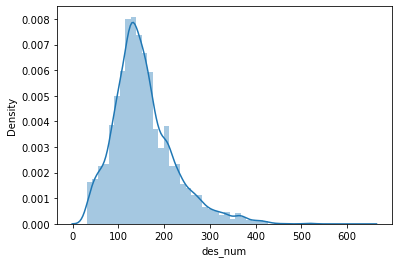

In [19]:
import seaborn as sns
sns.distplot(df[df['des_num']>30]['des_num'])

In [16]:
# 遍历文件
import os    
import glob
for filename in os.listdir(r'UBDC/sale_2020/'):
#     print(filename)
    filepath='UBDC/sale_2020/'+filename+'/*.csv'
#     print(filepath)
    for csvname in glob.glob(filepath):
        produce_clean_token(csvname,stopWords)

In [58]:
df_token=pd.read_csv('UBDC/sale_2020/LE/sale_valid_property_id_expanded_year_2020_area_LE_part_00006clean_token_complex.csv')

In [28]:
df_token1=pd.read_csv('UBDC/sale_2020/LE/sale_valid_property_id_expanded_year_2020_area_LE_part_00005clean_token_complex.csv')
# df_token1['des_clea'] = df_token1.des_clea.apply(ast.literal_eval)

In [38]:
# 合并为一个token csv 9g   6g


with open('a.csv', 'w') as f:
    
    pd.DataFrame(columns=['des_clea']).to_csv(f, index=False) # 去除index
    for filename in os.listdir(r'UBDC/sale_2020/'):
#     print(filename)
        filepath='UBDC/sale_2020/'+filename+'/*token*.csv'
#     print(filepath)
        for csvname in glob.glob(filepath):
            print(csvname)
            df_token=pd.read_csv(csvname)
            df_token.des_clea=df_token.des_clea.apply(ast.literal_eval)
            df_token.des_clea.to_csv(f,mode='a+',index=False,header=False)
            

#     df1 = pd.DataFrame([1, 2, 3], columns=['f'])
#     df2 = pd.DataFrame([4, 5, 6], columns=['f'])
# 	# 追加, 不写索引和表头
#     df1.to_csv(f, mode='a+', index=False,  header=False)
#     df2.to_csv(f, mode='a+', index=False,  header=False)
    
    


#         df_token=df_token.des_clea.apply(ast.literal_eval).tolist()
#         if( df_token_all==0):
#             df_token_all=df_token
#         else:
#         for a_list in df_token:
#             df_token_all.append(a_list)

UBDC/sale_2020/SN/sale_valid_property_id_expanded_year_2020_area_SN_part_00000clean_token_complex.csv
UBDC/sale_2020/SN/sale_valid_property_id_expanded_year_2020_area_SN_part_00003clean_token_complex.csv
UBDC/sale_2020/SN/sale_valid_property_id_expanded_year_2020_area_SN_part_00002clean_token_complex.csv
UBDC/sale_2020/SN/sale_valid_property_id_expanded_year_2020_area_SN_part_00004clean_token_complex.csv
UBDC/sale_2020/SN/sale_valid_property_id_expanded_year_2020_area_SN_part_00001clean_token_complex.csv
UBDC/sale_2020/SN/sale_valid_property_id_expanded_year_2020_area_SN_part_00005clean_token_complex.csv
UBDC/sale_2020/OL/sale_valid_property_id_expanded_year_2020_area_OL_part_00001clean_token_complex.csv
UBDC/sale_2020/OL/sale_valid_property_id_expanded_year_2020_area_OL_part_00000clean_token_complex.csv
UBDC/sale_2020/HD/sale_valid_property_id_expanded_year_2020_area_HD_part_00000clean_token_complex.csv
UBDC/sale_2020/HD/sale_valid_property_id_expanded_year_2020_area_HD_part_00001clea

In [37]:
for count in range(df_token.shape[0]):
    
    df_token1=df_token1.append(df_token.iloc[count])


In [2]:
df_all=pd.read_csv('2020_token_all.csv')

#####  N-gram

In [7]:
df_all_oneten=pd.read_csv('2020_token_oneten.csv')

In [9]:
%%time
df_all_oneten['des_clea'] = df_all_oneten.des_clea.apply(ast.literal_eval)

CPU times: user 1min 34s, sys: 2.28 s, total: 1min 37s
Wall time: 1min 37s


In [11]:
df_all_oneten.drop(df_all_oneten[df_all_oneten['des_clea']==0].index,inplace=True)

In [12]:
# df_all_oneten.des_clea=df_all_oneten.des_clea.apply(ast.literal_eval)
# df_all_oneten.des_clea
phrase_mode=Phrases(df_all_oneten.des_clea.tolist()) #训练n-gram模型


In [15]:
# save n-gram model
# phrase_mode.save('oneten_phrase_large.pkl')
frozen_model = Phraser(phrase_mode)
frozen_model.save('oneten_phrase.pkl')
# load model  很奇怪必须先训好了才能load
frozen_model = Phraser.load('oneten_phrase.pkl')

In [62]:
df_token['des_clea'] = df_token.des_clea.apply(ast.literal_eval)

ValueError: malformed node or string: ['absolutely', 'thrilled', 'delighted', 'offer', 'sale', 'exceptional', 'grade', 'ii', 'list', 'property', 'formally', 'school', 'house', 'approx', 'ha', 'considerably', 'lovingly', 'update', 'extend', 'standard', 'owner', 'effort', 'ha', 'retain', 'original', 'feature', 'original', 'sash', 'window', 'coving', 'stone', 'sill', 'door', 'fireplace', 'whilst', 'incorporate', 'modern', 'feature', 'life', 'bit', 'easy', 'radio', 'interlink', 'smoke', 'alarm', 'system', 'underfloor', 'heating', 'beautiful', 'property', 'comprises', 'entrance', 'hallway', 'impressive', 'lounge', 'bespoke', 'plan', 'kitchen', 'dining', 'utility', 'shower', 'exquisite', 'orangery', 'floor', 'offer', 'bedrooms', 'fit', 'wardrobe', 'fit', 'family', 'bathroom', 'original', 'roll', 'top', 'bath', 'spiral', 'staircase', 'lead', 'stunning', 'master', 'bedroom', 'suite', 'comprise', 'turreted', 'bedroom', 'seating', 'en', 'suite', 'master', 'bedroom', 'suite', 'window', 'stunning', 'view', 'reach', 'village', 'bradgate', 'park', 'front', 'property', 'low', 'maintenance', 'gravel', 'garden', 'tandem', 'gravel', 'driveway', 'provide', 'parking', 'landscape', 'private', 'rear', 'walled', 'garden', 'ha', 'stock', 'flower', 'bed', 'timber', 'garden', 'garden', 'independant', 'boiler', 'provide', 'gas', 'central', 'heating', 'provide', 'underfloor', 'heating', 'kitchen', 'orangery', 'hot', 'water', 'tank', 'immersion', 'provide', 'hot', 'water', 'bathroom', 'control', 'smart', 'nest', 'heating', 'system"desford', 'village', 'facility', 'shops', 'pharmacy', 'schools', 'doctors', 'surgery', 'dentists', 'recreational', 'traditional', 'village', 'pub', 'superb', 'road', 'link', 'leicester', 'city', 'centre', 'motorway', 'network', 'fosse', 'park', 'shopping', 'centre', 'rarely', 'doe', 'property', 'quality', 'market', 'internal', 'inspection', 'absolutely', 'imperative', 'standard', 'quality', 'outstanding', 'family', 'property', 'comprises', 'ground', 'floor', 'entrance', 'hall', 'window', 'front', 'cast', 'iron', 'radiator', 'storage', 'cupboard', 'stair', 'tiled', 'flooring', 'attractive', 'original', 'spindled', 'staircase', 'rise', 'floor', 'landing', 'lounge', 'bay', 'sash', 'window', 'front', 'attractive', 'wooden', 'shutter', 'ornate', 'cast', 'iron', 'fireplace', 'radiator', 'original', 'coving', 'ceiling', 'kitchen', 'dining', 'fitted', 'comprehensive', 'range', 'base', 'eye', 'level', 'unit', 'worktop', 'space', 'sink', 'unit', 'mixer', 'tap', 'integrated', 'dishwasher', 'integrate', 'wine', 'cooler', 'space', 'fridge', 'freezer', 'space', 'oven', 'range', 'build', 'microwave', 'period', 'fireplace', 'tiled', 'flooring', 'underfloor', 'heating', 'coving', 'ceiling', 'ceiling', 'spotlight', 'island', 'unit', 'breakfast', 'bar', 'delightful', 'window', 'seating', 'overlook', 'orangeryutlity', 'fitted', 'comprehensive', 'range', 'match', 'range', 'base', 'eye', 'level', 'unit', 'granite', 'worktop', 'space', 'inset', 'sink', 'mixer', 'tap', 'space', 'tumble', 'dryer', 'washing', 'machine', 'build', 'fridge', 'window', 'front', 'attractive', 'wooden', 'shutter', 'original', 'sash', 'window', 'rear', 'tiled', 'flooring', 'ceiling', 'spotlight', 'towel', 'rail', 'cupboard', 'housing', 'water', 'cylinder', 'door', 'orangery', 'fabulous', 'ideal', 'entertaining', 'double', 'door', 'lead', 'rear', 'garden', 'retaining', 'original', 'feature', 'prior', 'addition', 'orangery', 'expose', 'brickwork', 'original', 'stone', 'sill', 'sash', 'window', 'slate', 'tile', 'beautiful', 'benefit', 'underfloor', 'heating', 'build', 'storage', 'cupboardshower', 'tiled', 'underfloor', 'heating', 'walk', 'shower', 'rainfall', 'shower', 'wash', 'hand', 'basin', 'low', 'level', 'flush', 'w.c', 'etch', 'opaque', 'sash', 'window', 'heated', 'towel', 'rail', 'ceiling', 'spotlight', 'stairs', 'entrance', 'hall', 'rise', 'floor', 'landing', 'sash', 'window', 'front', 'etch', 'window', 'cast', 'iron', 'radiator', 'coved', 'ceilingbathroom', 'piece', 'suite', 'comprising', 'original', 'cast', 'iron', 'roll', 'top', 'bath', 'pedestal', 'wash', 'hand', 'basin', 'walk', 'tiled', 'shower', 'cubicle', 'low', 'level', 'flush', 'w.c', 'radiator', 'towel', 'rail', 'etch', 'sash', 'window', 'rear', 'tiled', 'flooring', 'half', 'height', 'tiling', 'coving', 'ceiling', 'ceiling', 'spotlight', 'build', 'cupboard', 'bedroom', 'sash', 'window', 'front', 'cast', 'iron', 'radiator', 'cast', 'iron', 'fireplace', 'fit', 'wardrobe', 'smoke', 'alarmbedroom', 'sash', 'window', 'rear', 'cast', 'iron', 'radiator', 'smoke', 'alarm', 'bedroom', 'sash', 'window', 'rear', 'feature', 'cast', 'iron', 'fireplace', 'fit', 'wardrobe', 'spot', 'lighting', 'smoke', 'alarm.aa', 'door', 'landing', 'access', 'fabulous', 'spiral', 'staircase', 'rise', 'floor', 'impressive', 'master', 'bedroom', 'suite', 'turreted', 'bedroom', 'stunning', 'addition', 'comprise', 'of;en', 'suite', 'shower', 'shower', 'cubicle', 'low', 'level', 'flush', 'w.c', 'basin', 'set', 'vanity', 'unit', 'tiled', 'flooring', 'sash', 'window', 'rear', 'seating', 'build', 'wardrobe', 'cupboard', 'smoke', 'alarm', 'cast', 'iron', 'radiator', 'sash', 'window', 'overlook', 'village', 'view', 'bradgate', 'parkturreted', 'bedroom', 'stunning', 'cast', 'iron', 'central', 'heating', 'radiatoroutside', 'front', 'gravelled', 'fore', 'garden', 'driveway', 'provide', 'parking', 'rear', 'delightful', 'mature', 'walled', 'rear', 'garden', 'stock', 'border', 'paved', 'patio', 'timber', 'garden', 'summerhouse', 'garden', 'office', 'family', 'light', 'power', 'door', 'provide', 'storage']

In [37]:
import csv
with open('oneten_ngram.csv', 'w') as f:
    writer = csv.writer(f)
    for phrase in df_token.des_clea.tolist():
        writer.writerow(str(frozen_model[phrase]))

In [38]:
# 成功逐行输出到csv 没去重
import csv
with open('oneten_ngram.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for phrase in df_all_oneten.des_clea.tolist():
        writer.writerow([frozen_model[phrase]]) #加了个中括号可以防止每个一个字母



## word2vec

In [9]:
df_all_oneten_ngram=pd.read_csv('oneten_ngram.csv')

In [7]:
type(df_all_oneten_ngram)

pandas.core.frame.DataFrame

In [11]:
%%time   
#less than 2min
df_all_oneten_ngram.columns={'des_clea'}
df_all_oneten_ngram.des_clea=df_all_oneten_ngram.des_clea.apply(ast.literal_eval)

CPU times: user 1min 21s, sys: 3.33 s, total: 1min 24s
Wall time: 1min 24s


In [49]:
import multiprocessing
multiprocessing.cpu_count()

16

In [12]:
%%time
# 用n-gram训的word2vev模型  1.5h

ngram_model = Word2Vec(sentences=df_all_oneten_ngram['des_clea'].values.tolist(), size=300, window=5, iter=200, 
                min_count=25, seed=8, workers=24)

CPU times: user 7h 34min 57s, sys: 4min 53s, total: 7h 39min 50s
Wall time: 1h 24min 35s


In [13]:
ngram_model.save('ngram_onten.model')

In [68]:
type(df_all_oneten_ngram)

pandas.core.series.Series

In [52]:
# 失败的txt尝试，输出n-gram的token，输出到txt文件可行但是读取回来是字符串转化为list内存不够
with open("test.txt","w") as f:
    for phrase in df_all_oneten.des_clea.tolist():
        f.write(str(frozen_model [phrase]))
f = open("test.txt")  #,encoding = "utf-8"
df_all_oneten_ngram=f.read()
df_all_oneten_ngram=ast.literal_eval(df_all_oneten_ngram) ##这个一直爆内存

In [126]:
# 没用n-gram训的word2vev模型，忘了
model = Word2Vec(sentences=df_all_oneten['des_clea'].values.tolist(), size=300, window=5, iter=200, 
                min_count=25, seed=8, workers=24)
model.save('oneten.model')
# df_all_oneten['des_clea'].values.tolist(

In [16]:
# 尝试合成一个list，失败
import os    
import glob
df_token_all=[]
for filename in os.listdir(r'UBDC/sale_2020/'):
#     print(filename)
    filepath='UBDC/sale_2020/'+filename+'/*token*.csv'
#     print(filepath)
    for csvname in glob.glob(filepath):
        print(csvname)
        df_token=pd.read_csv(csvname)
#         df_token=df_token.des_clea.apply(ast.literal_eval).tolist()
#         if( df_token_all==0):
#             df_token_all=df_token
#         else:
        for a_list in df_token:
            df_token_all.append(a_list)


IndentationError: unexpected indent (1069623139.py, line 18)

In [ ]:
# stepwise regression

from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm
  
data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
  
def stepwise_selection(X,y,initial_list=[],threshold_in=0.01,threshold_out = 0.05,verbose = True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
  
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included
  
result = stepwise_selection(X, y)
  
print('resulting features:')
print(result)

In [25]:
%%time
# 用n-gram训的word2vev模型  6g  
sentence=MySentences_word2vec()
ngram_model = Word2Vec(sentences=sentence, size=300, window=5, iter=5,
                min_count=25, seed=8, workers=16)
ngram_model.save('ngram_6g.model')

INFO - 17:09:25: collecting all words and their counts
INFO - 17:09:28: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:09:33: PROGRESS: at sentence #10000, processed 1892245 words, keeping 26963 word types
INFO - 17:09:40: PROGRESS: at sentence #20000, processed 3793350 words, keeping 33614 word types
INFO - 17:09:44: PROGRESS: at sentence #30000, processed 5690883 words, keeping 37214 word types
INFO - 17:09:49: PROGRESS: at sentence #40000, processed 7497849 words, keeping 49290 word types
INFO - 17:09:57: PROGRESS: at sentence #50000, processed 9973050 words, keeping 61399 word types
INFO - 17:10:02: PROGRESS: at sentence #60000, processed 12421750 words, keeping 72020 word types
INFO - 17:10:10: PROGRESS: at sentence #70000, processed 14871117 words, keeping 75652 word types
INFO - 17:10:14: PROGRESS: at sentence #80000, processed 17079879 words, keeping 83242 word types
INFO - 17:10:18: PROGRESS: at sentence #90000, processed 18589153 words, keeping 91

CPU times: user 4h 5min, sys: 11min 7s, total: 4h 16min 7s
Wall time: 3h 53s


In [27]:
ngram_model.train(sentence)

WARNING - 20:11:43: Effective 'alpha' higher than previous training cycles


ValueError: You must specify either total_examples or total_words, for proper job parameters updationand progress calculations. The usual value is total_examples=model.corpus_count.

# 伯明翰去重

In [15]:
df_b=pd.read_csv('UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00000.csv')
df_b.iloc[0].end_date
df_b['property_type'].notnull()

0       True
1       True
2       True
3       True
4       True
        ... 
8433    True
8434    True
8435    True
8436    True
8437    True
Name: property_type, Length: 8438, dtype: bool

In [13]:
df_b_token=pd.read_csv('UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00000clean_token_complex.csv')
df_b['token']=df_b_token["des_clea"]
df_b['token']=df_b['token'].apply(ast.literal_eval)
for row in df_b['token']:
    while '  ' in row:
        row.remove('  ')
df_b['token'].head()

0    [natural, light, flow, offer, wealth, feature,...
1    [brick, pave, herring, bone, driveway, lead, p...
2    [beautifully, bedroom, semi, detach, property,...
3    [situated, exceptionally, popular, road, boast...
4    [super, modern, detached, popular, location, b...
Name: token, dtype: object

In [16]:
df_b.drop(df_b[df_b.property_type.isnull()].index,inplace=True)
df_b.reset_index(drop=True,inplace=True)

In [8]:
#去重，保留相同id时间最靠后的一项
timedic={} #store time 
indexdic={}#store index to delete
delindex=[]
for count in range(df_b.shape[0]):
    key=df_b.iloc[count]['listing_id']
    time = datetime.datetime.strptime(df_b.iloc[count]['end_date'], "%Y-%m-%d") #时间字符串转time格式
    if not key in timedic:
        timedic.update({key:time})
        indexdic.update({key:count})
    elif(time>=timedic[key]):
        timedic.update({key:time})
        delindex.append(indexdic[key])
        indexdic.update({key:count})
df_b.drop(delindex,inplace=True) 
df_b.reset_index(drop=True,inplace=True)

In [9]:
# 提取出来的token先过n-gram再过word2vec，之后就是相似性检测了
for count in range(df_b['token'].shape[0]):
    df_b['token'].iloc[count]=frozen_model[df_b['token'].iloc[count]]

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## 相似度检测

In [46]:
ngram_model=Word2Vec.load('ngram_onten.model')

In [15]:
# 相似度
ngram_model.wv.most_similar(positive=df_b['token'][1][4])[0][0]

'leading'

In [27]:
for row in df_b['token'][0:100]:
    for token in row:
        if token in ngram_model.wv and ngram_model.wv.most_similar(positive=token,topn=1)[0][1]>0.8:
            print(token,':::',ngram_model.wv.most_similar(positive=token,topn=1),'\n')

SyntaxError: invalid syntax (2581549556.py, line 4)

In [2]:
# 为了构建词频矩阵临时抽出十分之一的去重phrase
a=pd.read_csv('2020_token_uni.csv')

In [8]:
oneten_uni

,des_clea
0,"['onward', 'chain', 'charles', 'harding', 'ple..."
10,"['house', 'annex', 'set', 'quiet', 'village', ..."
20,"['situated', 'cul', 'de', 'sac', 'location', '..."
30,"['complete', 'estate', 'agent', 'delighted', '..."
40,"['extended', 'semi', 'detached', 'family', 'si..."
...,...
3254800,"['ground', 'floor', 'sit', 'pvcu', 'double', '..."
3254810,"['quiet', 'cul', 'de', 'sac', 'location', 'sup..."
3254820,"['excellent', 'opportunity', 'downsize', 'bedr..."
3254830,"['bedroom', 'semi', 'detach', 'bungalow', 'acc..."


In [9]:
oneten_uni=a[a.index%10==0]
oneten_uni.des_clea=oneten_uni.des_clea.apply(ast.literal_eval)
# 成功逐行输出到csv
import csv
with open('oneten_uni_ngram.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for phrase in oneten_uni.des_clea.tolist():
        writer.writerow([frozen_model[phrase]]) #加了个中括号可以防止每个一个字母

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [16]:
%%time
# 词频矩阵
# des_clea=Mydes_clea()
onten_uni_ngram=pd.read_csv('oneten_uni_ngram.csv')
onten_uni_ngram.columns={'des_clea'}
vectorizer = CountVectorizer()  
X = vectorizer.fit_transform(onten_uni_ngram.des_clea)

CPU times: user 30.8 s, sys: 3.68 s, total: 34.5 s
Wall time: 35.5 s


In [29]:
transformer = TfidfTransformer() 
tfidf = transformer.fit_transform(X) 

In [86]:
len(vectorizer.get_feature_names())

387282

In [121]:
Xcsc=X.tocsc()

In [127]:
SUM=pd.DataFrame(list(vectorizer.get_feature_names()),columns=['word'])
SUM['sum']=0
for count in range(len(vectorizer.get_feature_names())):
    SUM['sum'].iloc[count]=Xcsc.getcol(count).toarray().sum()
    print(count,end='\r')
    

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [128]:
SUM=SUM.drop(delindex)

In [130]:
SUM.to_csv('tf6g.csv',index=False)

In [78]:
vectorizer.get_feature_names()

['___________________________________',
 '__________________________________________',
 '____________________________________________________________',
 '____________________________________________________________________________southall',
 '___________________________________________________________________________external',
 '___________________________________________________________________________sales',
 '______________________________________________________________________availabilityunit',
 '______________________________________________________________________overviewthe',
 '___________________________________________________________________plot',
 '______________________________________________________________dining',
 '______________________________________________________________excellent',
 '____________________________________________________________old',
 '___________________________________________________________availabilityplot_glen',
 '_____________________________

In [70]:
X[1].toarray() [tfidf[1].toarray() >0].sum()

52

In [35]:
len(vectorizer.get_feature_names()) #387282个词

387282

In [44]:
df_word_idf = pd.DataFrame(list(zip(vectorizer.get_feature_names(),transformer.idf_)),columns=['word','idf'])

for row in df_word_idf[0:2]:
    print(row)

word
idf


In [ ]:
delindex=[]
for count in range(df_word_idf.shape[0]):
    if df_word_idf['word'].iloc[count] not in ngram_model.wv:
        delindex.append(count)
df_word_idf_wv= df_word_idf.drop(delindex) # idf矩阵完成啦！！

In [19]:
def remove_notin_w2v(df_word_idf):
    delindex=[]
    for count in range(df_word_idf.shape[0]):
        if df_word_idf['word'].iloc[count] not in ngram_model.wv:
            delindex.append(count)
    df_word_idf_wv= df_word_idf.drop(delindex) # idf矩阵完成啦！！
    return df_word_idf_wv

In [131]:
df_word_idf_wv.to_csv('idf.csv',index=False)

In [88]:
 ngram_model.wv.most_similar(positive='aa',topn=1)[0][1]

0.3447900116443634

In [ ]:
# 相似度的两种思路：一种是用基于余弦相似度的wv的函数直接求出相似度最高的几个词再手动判断比如前三位是否相等来判断是否为同一单词的变形，比如现在分词，过去分词
# 二是判断是否为关键词，能否替换，这用到全局tfidf


In [99]:
SUM=pd.read_csv('tf6g.csv')
SUM['sum'][1]
SUM[SUM['word']==tmp[0][0]][sum]

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [134]:
tmp= ngram_model.wv.most_similar(positive='brick',topn=1)
SUM[SUM['word']==tmp[0][0]]['sum'].iloc[0]

40576

In [255]:
# tmp[0][0] in ngram_model.wv

alltfidf.describe()

,alltfidf
count,3.750500e+04
mean,4.886436e+03
std,3.407238e+04
min,1.299992e+01
25%,2.259035e+02
50%,4.171386e+02
75%,1.116959e+03
max,1.581267e+06


In [271]:
SUM['word'][alltfidf[alltfidf['alltfidf']>10000].index]

4                     abbey
57                  ability
58       ability_efficiency
83               absolutely
89                abundance
                ...        
37408                 yield
37421                  york
37436             yorkshire
37477               zanussi
37493                  zone
Name: word, Length: 2154, dtype: object

In [257]:
%%time
(SUM[SUM['word']==word]['sum'].iloc[0]*idf[idf['word']==word]['idf'].iloc[0])/max

CPU times: user 5.08 ms, sys: 0 ns, total: 5.08 ms
Wall time: 4.43 ms


0.0008303938808893124

In [252]:
%%time
# SUMval=SUM['word'].values
# tmp[0][0] in SUMval
            
# SUM[SUM['word']==tmp[0][0]]['sum'].iloc[0]
alltfidf=pd.DataFrame(columns={'alltfidf'})
max=0
for count in range(SUM.shape[0]):
    alltfidf.loc[alltfidf.size]=SUM['sum'].iloc[count]*idf['idf'].iloc[count]
    if SUM['sum'].iloc[count]*idf['idf'].iloc[count]>max:
        max=SUM['sum'].iloc[count]*idf['idf'].iloc[count]
        

            
max

CPU times: user 29.9 s, sys: 0 ns, total: 29.9 s
Wall time: 29.8 s


1581267.3925353806

In [303]:
word=df_b['token'].iloc[count][0]
word='offering'
df_b['token'].iloc[count][0]
delindex

[]

In [304]:
%%time
# 相似度检测替换 2.10h
for count in range(df_b.shape[0]):
    print(count)
    delindex=[]
    for count1 in range(len(df_b['token'].iloc[count])):
        word=df_b['token'].iloc[count][count1]
        if word not in ngram_model.wv :
            delindex.append(count1)
        else:
            tmp= ngram_model.wv.most_similar(positive=word,topn=1)
            SUMval=SUM['word'].values
            if (tmp[0][1]>0.8 
            and tmp[0][0] in SUMval 
            and word in SUMval  
            and SUM_dict[tmp[0][0]]>SUM_dict[word]
            and SUM[word]*idf_dict[word]<10000):
#             and SUM[SUM['word']==tmp[0][0]]['sum'].iloc[0]>SUM[SUM['word']==word]['sum'].iloc[0] 
#             and SUM[SUM['word']==word]['sum'].iloc[0]*idf[idf['word']==word]['idf'].iloc[0]<10000):
                df_b['token'].iloc[count][count1]=tmp[0][0]
    for  x in delindex:
        df_b['token'].iloc[count].pop(x)
                

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [314]:
for count in range(1):
    print(count)
    delindex=[]
    for count1 in range(len(df_b['token'].iloc[count])):
        word=df_b['token'].iloc[count][count1]
        if word not in ngram_model.wv :
            print('1')
            delindex.append(count1)
        else:
            tmp= ngram_model.wv.most_similar(positive=word,topn=1)
            SUMval=SUM['word'].values
            if (tmp[0][1]>0.8 
            and tmp[0][0] in SUMval 
            and word in SUMval  
            and SUM[SUM['word']==tmp[0][0]]['sum'].iloc[0]>SUM[SUM['word']==word]['sum'].iloc[0] 
            and SUM[SUM['word']==word]['sum'].iloc[0]*idf[idf['word']==word]['idf'].iloc[0]<10000):
                print('2')
                df_b['token'].iloc[count][count1]=tmp[0][0]
    for  x in delindex:
        df_b['token'].iloc[count].pop(x)

0


In [ ]:
for count in range(df_b.shape[0]):
    print(count)
    delindex=[]
    for count1 in range(len(df_b['token'].iloc[count])):
        word=df_b['token'].iloc[count][count1]
        if word not in ngram_model.wv :
            delindex.append(count1)
        else:
            tmp= ngram_model.wv.most_similar(positive=word,topn=1)
            SUMval=SUM['word'].values
            if (tmp[0][1]>0.8 
            and tmp[0][0] in SUMval 
            and word in SUMval  
            and SUM[SUM['word']==tmp[0][0]]['sum'].iloc[0]>SUM[SUM['word']==word]['sum'].iloc[0] 
            and SUM[SUM['word']==word]['sum'].iloc[0]*idf[idf['word']==word]['idf'].iloc[0]<10000):
                df_b['token'].iloc[count][count1]=tmp[0][0]
    for  x in delindex:
        df_b['token'].iloc[count].pop(x)

In [306]:
df_b['token'].to_csv('UBDC/sale_2020/B/00000_token_sim.csv')

## tfidf关键词提取-特定地区

In [5]:
df_b_token_sim=pd.read_csv('UBDC/sale_2020/B/00000_token_sim.csv')
vectorizer = CountVectorizer()
X_b = vectorizer.fit_transform(str(row) for row in df_b_token_sim['token']) #还非得是str
# df_b['token'][1]


In [8]:
word = vectorizer.get_feature_names() 
# for w in set(eval(df_b_token_sim['token'].iloc[3060])):
#     if w not in word:
#         print(w)


In [329]:
count=0
for a in word:
    if a[0]=='_':
        count=count+1
count   

31

In [110]:
df_word =  pd.DataFrame(X_b.toarray(),columns=vectorizer.get_feature_names())

In [111]:
# df_word=remove_notin_w2v(df_word)
df_wordT=df_word.T
df_wordT

,0,1,2,3,4,5,6,7,8,9,...,8252,8253,8254,8255,8256,8257,8258,8259,8260,8261
_aerial,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_albans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_andrew,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_anne,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zone,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zoned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zoned_underfloor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zoo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
df_wordT.sum()

0       2008
1       8433
2        616
3        882
4       2835
        ... 
8257     669
8258    1580
8259    2141
8260     490
8261    2228
Length: 8262, dtype: int64

In [96]:
%%time
# df_wordT
'aa' in idf['word'].values

CPU times: user 496 µs, sys: 0 ns, total: 496 µs
Wall time: 501 µs


True

In [5]:
df_wordT=pd.read_csv('df_wordT.csv')
df_wordT.drop('Unnamed: 0',axis=1,inplace=True)
df_wordT.set_index('Unnamed: 0.1',inplace=True)
# df_wordT.to_csv('df_wordT.csv')

In [8]:
%%time
# 去个重1h就离谱 , 不是了，过了相似度检测大部分不在wv的都踢出去了
for word in df_wordT.index:
    if word not in ngram_model.wv or word not in idf_dict.keys():
        df_wordT.drop(word,inplace=True)
        print(word)
        


bank_statement
cofton_park
dolce_walnut
laufen_pro
original_minton
rivendell
secondary_schools
walking_distance
CPU times: user 709 ms, sys: 683 ms, total: 1.39 s
Wall time: 1.38 s


In [108]:
%%time
# df_wordT.index[x]
# x=1
# y=1
# df_wordT.iloc[x][y]=(df_wordT.iloc[x][y]/len(df_b_token_sim['token'][y]))*idf_dict[df_wordT.index[x]]
print('x:',x,'y:',y,end='\r')

CPU times: user 540 µs, sys: 0 ns, total: 540 µs
Wall time: 296 µs


In [7]:
%%time
# compute tfidf 太慢了  2h 51min 38s
for x in range(df_wordT.shape[0]): #word
    for y in range(df_wordT.shape[1]): # number of house
        if df_wordT.iloc[x][y]!=0:
            df_wordT.iloc[x][y]=df_wordT.iloc[x][y]*idf_dict[df_wordT.index[x]]
#             a=(df_wordT.iloc[x][y]/len(df_b_token_sim['token'][y]))*idf_dict[df_wordT.index[x]]*10000
            print(x,end='\r')
            
            

KeyError: 'bank_statement'

In [9]:
df_wordTT=df_wordT.T
arr_word=df_wordTT.to_numpy().astype(float)

In [10]:
# 巨快无比 compute tfidf array much faster than dataframe
for countx in range(arr_word.shape[0]): #des
    print(countx,end='\r')
    for county in range(arr_word.shape[1]): #word
        if arr_word[countx][county]!=0:
            arr_word[countx][county]=arr_word[countx][county]*idf_dict[df_wordT.index[county]]

In [17]:
#   
df_b['tfidf_key']=0
for countx in range(arr_word.shape[0]): #des
    tmplist=[]
    for x in arr_word[countx].argsort()[-20:]:
        tmplist.append(df_wordT.index[x])
    df_b['tfidf_key'].iloc[countx]=tmplist

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
from scipy.sparse import csr_matrix
csr_matrix((3, 4), dtype=np.int8).toarray()

In [68]:
vectorizer = CountVectorizer()  
X = vectorizer.fit_transform(str(x) for x in df_b['tfidf_key'])
word=vectorizer.get_feature_names()
tfidfX=X.toarray()
tfsum=[]
for x in range(tfidfX.shape[1]):
    tfsum.append(tfidfX[:,x].sum())
aa=pd.DataFrame(tfsum,index=word)
aa.to_csv('关键词数量.csv')


In [69]:
count=0
for w in df_wordT.index:
    if w not in word:
        count=1+count
print(count)

2056


In [77]:
aa.sort_values(by=0,ascending=False)[0:500].index  #top500 word

Index(['window', 'double', 'radiator', 'glaze', 'rear', 'door', 'ceiling',
       'light', 'central', 'heating',
       ...
       'viewingssome_pertain', 'security', 'main', 'ensure_happy', 'olton',
       'porchhaving', 'district', 'fan', 'shirley', 'tv_aerial'],
      dtype='object', length=500)

## regression

In [51]:
pd.set_option('display.max_columns', None)
dropcol=['listing_id',
         'start_date',
         'price_first',
         'price_min',
         'price_max',
         'price_unique',
         'price_flag',
         'num_bed_first',
         'num_bed_min',
         'num_bed_max',
         'listing_status',
         'epc_list',
         'details_url',
         'short_description',
         'category',
         'description',
         'zdocument',
         'branch_id',
         'image_url',
         'agent_logo',
         'agent_phone',
         'agent_address',
         'agent_postcode',
         'image_caption',
         'thumbnail_url',
         'floor_plan',
         'original_image',
         ]
# df_b.drop(dropcol,axis=1,inplace=True)
# df_b.drop(df_b[df_b['num_bath_min']!=df_b['num_bath_max']].index,inplace= True)
# df_b.drop(df_b[df_b['num_floors_min']!=df_b['num_floors_max']].index,inplace= True)
# df_b.drop(df_b[df_b['num_reception_min']!=df_b['num_reception_max']].index,inplace= True)
# df_b.drop(['num_floors_min','num_bath_min','num_reception_min'],axis=1,inplace=True)

In [58]:
# df_b[df_b['num_reception_min']!=df_b['num_reception_max']].shape
df_b_postion=df_b[['pcu','lon','lat','address','street_name','property_num','post_town']]
tmplist=['pcu','lon','lat','address','street_name','property_num','post_town','country','agent_name','bullet']
df_b.drop(tmplist,axis=1,inplace=True)

In [86]:
# 求des的哑变量
top500=aa.sort_values(by=0,ascending=False)[0:500].index  #top500 word
# df_wordTT.iloc[df_b.index].T.loc[top500].T#des index
df_top500=df_wordTT.iloc[df_b.index].loc[:,top500].copy()

In [100]:
# change word frequency to dum,change num to 1
for x in range(df_top500.shape[0]):
    print(x,end='\r')
    for y in range(df_top500.shape[1]):
        if df_top500.iloc[x,y]!=0:
            df_top500.iloc[x,y]=1

In [115]:
df_top500.index=df_top500.index.astype('int64')
df_b_reg=pd.concat([df_b,df_top500],axis=1)

In [120]:
df_b_tfkey=df_b_reg[['tfidf_key']]  # sotre tfidf keyword
df_b_reg.drop(['tfidf_key'],axis=1,inplace=True)

In [142]:
# process date
for count in range(df_b_reg.shape[0]):
    df_b_reg.end_date.iloc[count] = datetime.datetime.strptime(df_b_reg.end_date.iloc[count], "%Y-%m-%d")
mindate=df_b_reg.end_date.min()
for count in range(df_b_reg.shape[0]):
    df_b_reg.end_date.iloc[count] = (df_b_reg.end_date.iloc[count]-mindate).days
df_b_reg.end_date=df_b_reg.end_date.astype(int)

In [143]:
df_b_reg_dum=pd.get_dummies(df_b_reg)

In [148]:
# get the input of regression
df_b_reg_dum.to_csv('b_000_dum.csv')

In [152]:
df_b_reg_dum.head(1)

,end_date,price_last,num_bed_last,bed_flag,num_floors_max,num_bath_max,num_reception_max,window,double,radiator,glaze,rear,door,ceiling,light,central,heating,property,front,max,birmingham,elevation,bedroom,flooring,wall,glazed,lead,floor,bay,buyer,reception,upvc,apartment,diner,garage,aspect,conservatory,garden,family,carpet,mount,laminate,provide,surveyor,advise,obscure,access,porch,upward_chain,wc,extended,min,fit,company,solely_vendor,recess,solihull,power,guest,downstairs,communal,electric,tiled,redditch,fore,space,bromsgrove,road,city,school,splash_prone,offer,shower,single,verification_solicitor,lounge,semi,heater,storage,en,sutton_coldfield,coving,development,landing,green,dimensions,suite,modern,breakfast,sized,vendor,tile,utility,hallway,centre,glazing,spotlight,size,wardrobe,overlook,mile,gas,panel,epc,cupboard,estate_agency,comprises,park,secure,local,feature,price,refit,detached,terrace,hall,ep_rating,allocate,wooden,master,wood,driveway,style,spacious,call,time,plan,upstairs,auction,entrance,separate,build,services,sale,landingbedroom,perfect,email,investor,extend,flush,tamworth,comprise,village,viewing,benefit,traditional,dixons,residence,solihull_fastest,balcony,tiling,harborne,notice_dm,panelled,summary,ideal,potential,living,spot,enjoy,west_bromwich,superb,pointbedroom,unit,dm,ground,market_appraisal,heath,ceramic,erdington,pleasant,longbridge,investment,situate,virtual,solihull_metropolitan,dining,location,stunning,store,agent,comprising,confirmation,pleased,radiatorbedroom,advisor,lovely,kings_norton,jewellery_quarter,northfield,homes,mid,block_pave,moseley,house,town,mid_terraced,fenced_boundary,generous,detach,opaque,fantastic,parking,buy,fitted,borough_council,detail,live,queen_elizabeth,vacant_possession,purchaser,lease,highly,bungalow,internal,bedrooms,private,obligation,lean,delightful,contemporary,bournville,study,rent,kingfisher,intercom,train,contact,beautifully,jct,ha,cul_de,legal,locate,opportunity,verify,paved,integrated,original,freehold,link,tap,require,sac,luxury,maintain,book,heated,mixer,view,details,beautiful,reserve,initial,lighting,chain,attractive,wet,subject,splash,wardrobes,burchell_edwards,modernisation,plenty,gardenhaving,rise,lickey_hills,plot,party,junction,ensuite,cultural_attraction,oak,expense_burchell,purchase,prospective,measurement,chimney_breast,charge,level,flat,centrally_heat,stair,ideally,solicitors,residential,accuracy,hospital,edgbaston,maintenance,rubery,maxbedroom,motorway,street,landscape,set,sought,radiate,low,recommend,arrange,sell,newly,middle,chrome,inset,midlands,halesowen,epc_rating,patio,sutton,oldbury,transport,carpeted,corner,excellent,car,fire,hagley,ample,drive,cloakroom,slabbed,maxkitchen,decorative,stairs,essential,integral,await_confirmation,popular,lobby,advice,approx,maisonette,barnt_green,exceptionally,seek,website,gated,primary,nearby,tenure,bathroom,white,verification,entry,vinyl,professional,selly_oak,picture,schooling,easy,accommodation,pvc,lot,estate_agents,block,terraced,gardens,surround,share,annum,immaculately,loft,leasehold,south,eatery,convenient,doors,mature,built,approachthe,rowley_regis,offering,rely,delighted,short,understand,tv,kitchen,maxen,service,finish,facility,complimentary,walk,canal,bed,integrate,courtyard,refurbish,guide,hot_cold,university,bearwood,cost,distance,kings,landinghaving,halllounge,match,branch,decking,bathroomhaving,conveniently,timber,fireplace,glass,rail,consist,boast,system,edwards,sink,layout,photograph,accurate,improve,legal_pack,band,foregarden,warley_woods,tudor_grange,slide,shopping,complete,exchange,benefiting,furniture,tenant,certificate_pdf,located,quiet_cul,frost,de_sac,recessed,plentiful,method_auction,toilet,extension,close,remote_bidding,specific_write,doorway,commit_expenditure,leading,exclude,pack,couple,yardley,estate,features,lawned,consumer_protection,create,station,route,landingmaster,approach,rental,gardenpaved,superbly,solicitor,description,coleshill,boundary,additional,top,frontage,dressing,

In [153]:
# train set and test set
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(df_b_reg_dum.drop(['price_last'], axis = 1), df_b_reg_dum.price_last, random_state=random_state_split)

### LASSO

In [180]:
lasso_model = Lasso(max_iter=10e7, normalize=True)
lasso_model.fit(X=train_x, y=train_y)

Lasso(max_iter=100000000.0, normalize=True)

In [182]:
lasso_model.score(X=train_x, y=train_y)

0.7568526296278009

In [181]:
lasso_model.score(X=test_x, y=test_y)

0.6613286479890124

In [203]:
pd.set_option('display.max_rows', 200)
df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
df_coef_lasso[df_coef_lasso.coef==0]

,var,coef
2,bed_flag,-0.0
6,window,0.0
7,double,0.0
11,door,0.0
13,light,0.0
15,heating,0.0
30,upvc,-0.0
31,apartment,-0.0
36,garden,0.0
37,family,-0.0


In [195]:
alphas = 10**np.linspace(- 3, 3, 100) 


In [197]:
%%time
lasso_cv = LassoCV(alphas = alphas, normalize= True, cv = 20, max_iter= 10000).fit(train_x, train_y)

CPU times: user 5min 59s, sys: 16min 17s, total: 22min 16s
Wall time: 2min 42s


In [163]:
from sklearn.linear_model import LassoCV
import time
list_alphas = [.1, .5, 1, 10, 100, 1000, 10000]
start_time = time.time()
lasso_cv = LassoCV(cv=20, alphas=list_alphas).fit(train_x, train_y)
fit_time = time.time() - start_time

/opt/conda/envs/sds2021/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55349651711.34375, tolerance: 21655923585.44064
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15062369569210.984, tolerance: 21655923585.44064
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14659747234708.238, tolerance: 21655923585.44064
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/sklearn/linea

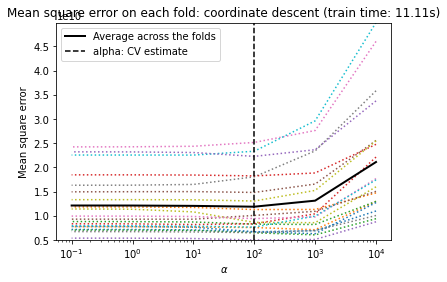

In [169]:
import matplotlib.pyplot as plt

ymin, ymax = np.min(lasso_cv.mse_path_), np.max(lasso_cv.mse_path_)
# lasso = model[-1]
plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle=":")
plt.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)"
)

In [204]:
fit_time

best_alpha=lasso_cv.alpha_

In [200]:
lasso_model = Lasso(max_iter=10e7, normalize=True, alpha = best_alpha_)
lasso_model.fit(X=train_x, y=train_y)
print(lasso_model.score(train_x, train_y))

0.7494481656499059


In [201]:
print(lasso_model.score(test_x, test_y))

0.664613422349507


## 语料库去重

In [35]:
countx=0
for filename in os.listdir(r'UBDC/sale_2020/'):
#     print(filename)
    filepath='UBDC/sale_2020/'+filename+'/*token*.csv'
#     print(filepath)
    for csvname in glob.glob(filepath):
#         print(csvname)
        df_token=pd.read_csv(csvname)  #token file
        df=pd.read_csv(csvname[0:-23]+'.csv')  #
        df_token.des_clea=df_token.des_clea.apply(ast.literal_eval)
#         df['token']=df_token["des_clea"] #先不加了，等phrase再加到源文件里
        timedic={} #store time 
        indexdic={}#store index to delete
        delindex=[]
        for count in range(df.shape[0]):
            if df_token['des_clea'].iloc[count]==0: #去掉0 没有description的情况
                delindex.append(count)        
            key=df.iloc[count]['listing_id']
            time = datetime.datetime.strptime(df.iloc[count]['end_date'], "%Y-%m-%d") #时间字符串转time格式
            if not key in timedic:
                timedic.update({key:time})
                indexdic.update({key:count})
            elif(time>timedic[key]):
                timedic.update({key:time})
                delindex.append(indexdic[key])
                indexdic.update({key:count})
            else:
                delindex.append(count)       
        df.drop(list(set(delindex)),inplace=True) 
        df_token.drop(delindex,inplace=True)
        df.reset_index(drop=True,inplace=True)
        df_token.reset_index(drop=True,inplace=True)
        for row in df_token['des_clea']:
            while '  ' in row:
                row.remove('  ')
        df_token.des_clea.to_csv(csvname,encoding="utf_8_sig")
        df.to_csv(csvname[0:-23]+'.csv',encoding="utf_8_sig",index=False)
        countx=countx+1
        print(countx,end='\r')
        
        

ValueError: time data '2020/7/1' does not match format '%Y-%m-%d'

In [31]:
a=[1,2,3,1]
list(set(a))

[1, 2, 3]

In [138]:
count=0
for filename in os.listdir(r'UBDC/sale_2020/'):
#     print(filename)
    filepath='UBDC/sale_2020/'+filename+'/*token*.csv'
#     print(filepath)
    for csvname in glob.glob(filepath):
        count=count+1
        print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [37]:
# test
df_token=pd.read_csv(csvname)  #token file
df=pd.read_csv(csvname[0:-23]+'.csv')  #
df_token.des_clea=df_token.des_clea.apply(ast.literal_eval)
for row in df_token['des_clea']:
    while '  ' in row:
            row.remove('  ')
df['token']=df_token["des_clea"] 
timedic={} #store time 
indexdic={}#store index to delete
delindex=[]
for count in range(df.shape[0]):
    key=df.iloc[count]['listing_id']
    time = datetime.datetime.strptime(df.iloc[count]['end_date'], "%Y/%m/%d") #时间字符串转time格式
    if not key in timedic:
        timedic.update({key:time})
        indexdic.update({key:count})
    elif(time>timedic[key]):
        timedic.update({key:time})
        delindex.append(indexdic[key])
        indexdic.update({key:count})
    else:
        delindex.append(count)   
df.drop(delindex,inplace=True) 
df_token.drop(delindex,inplace=True)
df.reset_index(drop=True,inplace=True)
df_token.reset_index(drop=True,inplace=True)
df_token.des_clea.to_csv(csvname,encoding="utf_8_sig") #ensure no index
df.to_csv(csvname[0:-23]+'.csv',encoding="utf_8_sig", index=False)

In [10]:
df1=pd.read_csv('UBDC/sale_2020/CO/sale_valid_property_id_expanded_year_2020_area_CO_part_00004.csv')

In [48]:
df_token=pd.read_csv(csvname) 
df_token.reset_index(drop=True,inplace=True)
df_token.des_clea.to_csv(csvname,encoding="utf_8_sig")

In [5]:
df_token=pd.read_csv(csvname,index_col=0) 
df_token

,des_clea
0,"['descriptionwe', 'pleased', 'offer', 'sale', ..."
1,"['kings', 'delighted', 'bedroom', 'terrace', '..."
2,"['reserve', 'receive', 'millington', 'travel',..."
3,"['attractive', 'individually', 'design', 'bedr..."
4,"['maintain', 'bedroomed', 'semi', 'detach', 'f..."
...,...
8325,"['location', 'location', 'location', 'seek', '..."
8326,"['save', 'money', 'energy', 'bill', 'build', '..."
8327,"['summarya', 'beautifully', 'unique', 'semi', ..."
8328,"['sale', 'online', 'conditional', 'auction', '..."


In [17]:
df=pd.read_csv(csvname[0:-23]+'.csv') 
df.head()

,listing_id,property_type,start_date,end_date,price_first,price_last,price_min,price_max,price_unique,price_flag,...,agent_phone,agent_address,agent_postcode,image_caption,thumbnail_url,floor_plan,original_image,bullet,lad20nm,token
0,54565390,Flat,2020-03-14,2020/7/1,118000,118000,118000,118000,[118000],1,...,0116 448 9093,"95 Narborough Road, Leicester",LE3 0PA,NaN,https://lid.zoocdn.com/80/60/9162d41de2dc4ed59...,NaN,"[""https://lc.zoocdn.com/9162d41de2dc4ed597786d...","[""One bedroom apartment"", ""Within desirable co...",Leicester,"['descriptionwe', 'pleased', 'offer', 'sale', ..."
1,53672535,End terrace house,2019/12/11,2020/7/21,180000,170000,170000,180000,[180000 170000],2,...,0116 484 9563,"297 Uppingham Road, Leicester",LE5 4DG,NaN,https://lid.zoocdn.com/80/60/dce0e754d2698ab49...,"[""https://lc.zoocdn.com/edbd4b5d3b1b135e0615b4...","[""https://lc.zoocdn.com/dce0e754d2698ab49b4303...","[""Perfect for investors/ first time buyers"", ""...",Leicester,"['kings', 'delighted', 'bedroom', 'terrace', '..."
2,57379564,Semi-detached house,2021/1/13,2021/3/31,299995,299995,299995,299995,[299995],1,...,0116 484 9501,"13 The Nook, Anstey, Leicester",LE7 7AZ,Holdenby - Plot 19.Jpg,https://lid.zoocdn.com/80/60/412b9508bef6530fc...,NaN,"[""https://lc.zoocdn.com/412b9508bef6530fcc120c...","[""Stunning open plan living to suit todays mod...",Charnwood,"['reserve', 'receive', 'millington', 'travel',..."
3,55788796,Detached house,2020/8/8,2020/8/17,475000,475000,475000,475000,[475000],1,...,0116 484 9841,"27-30 Halford Street, Leicester",LE1 1JB,Front,https://lid.zoocdn.com/80/60/65f849a722c2016d2...,"[""https://lc.zoocdn.com/8ad99e4d7552f5922b2f61...","[""https://lc.zoocdn.com/65f849a722c2016d2ca990...",[],Charnwood,"['attractive', 'individually', 'design', 'bedr..."
4,52557011,Semi-detached house,2019/10/1,2020/6/24,250000,240000,240000,250000,[250000 240000],2,...,024 7511 8874,"Nationwide Estate Agent, Head Office: Suite 7,...",B90 4RZ,Front View,https://lid.zoocdn.com/80/60/27274f0f1aa9f3137...,"[""https://lc.zoocdn.com/669a73cbff2225fdf0155a...","[""https://lc.zoocdn.com/27274f0f1aa9f31378bb52...","[""Semi-Detached House"", ""Three Bedrooms"", ""Thr...",Oadby and Wigston,"['maintain', 'bedroomed', 'semi', 'detach', 'f..."


In [60]:
df=pd.read_csv(csvname[0:-23]+'.csv',index_col=0) 
df

,listing_id,property_type,start_date,end_date,price_first,price_last,price_min,price_max,price_unique,price_flag,...,agent_phone,agent_address,agent_postcode,image_caption,thumbnail_url,floor_plan,original_image,bullet,lad20nm,token
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,54565390,Flat,2020-03-14,2020-07-01,118000,118000,118000,118000,[118000],1,...,0116 448 9093,"95 Narborough Road, Leicester",LE3 0PA,NaN,https://lid.zoocdn.com/80/60/9162d41de2dc4ed59...,NaN,"[""https://lc.zoocdn.com/9162d41de2dc4ed597786d...","[""One bedroom apartment"", ""Within desirable co...",Leicester,"['descriptionwe', 'pleased', 'offer', 'sale', ..."
1,53672535,End terrace house,2019-12-11,2020-07-21,180000,170000,170000,180000,[180000 170000],2,...,0116 484 9563,"297 Uppingham Road, Leicester",LE5 4DG,NaN,https://lid.zoocdn.com/80/60/dce0e754d2698ab49...,"[""https://lc.zoocdn.com/edbd4b5d3b1b135e0615b4...","[""https://lc.zoocdn.com/dce0e754d2698ab49b4303...","[""Perfect for investors/ first time buyers"", ""...",Leicester,"['kings', 'delighted', 'bedroom', 'terrace', '..."
2,57379564,Semi-detached house,2021-01-13,2021-03-31,299995,299995,299995,299995,[299995],1,...,0116 484 9501,"13 The Nook, Anstey, Leicester",LE7 7AZ,Holdenby - Plot 19.Jpg,https://lid.zoocdn.com/80/60/412b9508bef6530fc...,NaN,"[""https://lc.zoocdn.com/412b9508bef6530fcc120c...","[""Stunning open plan living to suit todays mod...",Charnwood,"['reserve', 'receive', 'millington', 'travel',..."
3,55788796,Detached house,2020-08-08,2020-08-17,475000,475000,475000,475000,[475000],1,...,0116 484 9841,"27-30 Halford Street, Leicester",LE1 1JB,Front,https://lid.zoocdn.com/80/60/65f849a722c2016d2...,"[""https://lc.zoocdn.com/8ad99e4d7552f5922b2f61...","[""https://lc.zoocdn.com/65f849a722c2016d2ca990...",[],Charnwood,"['attractive', 'individually', 'design', 'bedr..."
4,52557011,Semi-detached house,2019-10-01,2020-06-24,250000,240000,240000,250000,[250000 240000],2,...,024 7511 8874,"Nationwide Estate Agent, Head Office: Suite 7,...",B90 4RZ,Front View,https://lid.zoocdn.com/80/60/27274f0f1aa9f3137...,"[""https://lc.zoocdn.com/669a73cbff2225fdf0155a...","[""https://lc.zoocdn.com/27274f0f1aa9f31378bb52...","[""Semi-Detached House"", ""Three Bedrooms"", ""Thr...",Oadby and Wigston,"['maintain', 'bedroomed', 'semi', 'detach', 'f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8325,56589725,Terraced house,2020-10-14,2020-12-14,210000,200000,200000,210000,[210000 200000],2,...,0116 484 0630,"3 Oswin Road, Leicester",LE3 1HR,NaN,https://lid.zoocdn.com/80/60/e8e5aa23bd2d9171a...,"[""https://lc.zoocdn.com/c5cb8d913068866488cdf2...","[""https://lc.zoocdn.com/e8e5aa23bd2d9171a68721...","[""Perfect home in popular location"", ""Garage i...",Blaby,"['location', 'location', 'location', 'seek', '..."
8326,56630375,Flat,2021-03-03,2021-03-31,190995,190995,190995,190995,[190995],1,...,0116 484 9601,"Somerset Avenue, Leicester",LE4 0JY,Coleford Lounge,https://lid.zoocdn.com/80/60/0e005b8bf34e1a1f7...,"[""https://lc.zoocdn.com/51c92f1c5a54c34d63e0fb...","[""https://lc.zoocdn.com/0e005b8bf34e1a1f7f7a7e...","[""Second floor apartment"", ""Close to Leicester...",Leicester,"['save', 'money', 'energy', 'bill', 'build', '..."
8327,52419362,Semi-detached bungalow,2019-10-01,2019-11-06,180000,180000,180000,180000,[180000],1,...,01572 501946,"4 Market Place, Oakham",LE15 6DY,NaN,https://lid.zoocdn.com/80/60/88ec3dd7845337da1...,"[""https://lc.zoocdn.com/2c92575dab882f44515133...","[""https://lc.zoocdn.com/88ec3dd7845337da1a290a...","[""Two Bedrooms"", ""Single Storey Living"", ""Livi...",Rutland,"['summarya', 'beautifully', 'unique', 'semi', ..."


In [42]:
a=pd.read_csv('2020_token_uni.csv')

In [ ]:
%%time #超时 6g直接读内存也不行
a.des_clea=a.des_clea.apply(ast.literal_eval)

In [20]:
# 迭代器-训n-gram用
class MySentences(object):
#     def __init__(self, dirname):
#         self.dirname = dirname
 
    def __iter__(self):
        for filename in os.listdir('UBDC/sale_2020/'):
            
            filepath='UBDC/sale_2020/'+filename+'/*token*.csv'
            #     print(filepath)
            for csvname in glob.glob(filepath):
            #         print(csvname)
                df_token=pd.read_csv(csvname)  #token file
#                 df=pd.read_csv(csvname[0:-23]+'.csv')  #
                df_token.des_clea=df_token.des_clea.apply(ast.literal_eval)
                for row in df_token.des_clea.tolist():
                    yield row
                

In [54]:
# 迭代器-构建词频矩阵用 未完工先用了oneten 好像不行
class Mydes_clea(object):
#     def __init__(self, dirname):
#         self.dirname = dirname
 
    def __iter__(self):
        for filename in os.listdir('UBDC/sale_2020/'):
            
            filepath='UBDC/sale_2020/'+filename+'/*token*.csv'
            #     print(filepath)
            for csvname in glob.glob(filepath):
            #         print(csvname)
                df_token=pd.read_csv(csvname)  #token file
#                 df=pd.read_csv(csvname[0:-23]+'.csv')  #
#                 df_token.des_clea=df_token.des_clea.apply(ast.literal_eval)
                yield df_token.des_clea
                    
                

In [ ]:
count_vec_iter=0

In [21]:
# 迭代器-训word2vec用
class MySentences_word2vec(object):
#     def __init__(self, dirname):
#         self.dirname = dirname
 
    def __iter__(self):
        for filename in os.listdir('UBDC/sale_2020/'):
            
            filepath='UBDC/sale_2020/'+filename+'/*complex*.csv'
            #     print(filepath)
            for csvname in glob.glob(filepath):
#                 print(count_v)
                df_token=pd.read_csv(csvname)  #token file
#                 df=pd.read_csv(csvname[0:-23]+'.csv')  #
                df_token.des_clea=df_token.des_clea.apply(ast.literal_eval)
                for row in df_token.des_clea.tolist():
                    yield frozen_model[row]

In [139]:
  #token file
#                 df=pd.read_csv(csvname[0:-23]+'.csv')  #
                df_token.des_clea=df_token.des_clea.apply(ast.literal_eval)
                for row in df_token.des_clea.tolist():
                    yield [frozen_model[row]

SyntaxError: unexpected EOF while parsing (1503488721.py, line 5)

In [142]:
df_token=pd.read_csv(csvname)
df_token.des_clea=df_token.des_clea.apply(ast.literal_eval)


In [9]:
%%time    
#1.5h 6g ngram
sentence=MySentences()

phrase_mode=Phrases(sentence)

CPU times: user 1h 30min 46s, sys: 17 s, total: 1h 31min 3s
Wall time: 1h 31min 12s


In [18]:
(
0.9270
-0.8750)


0.052000000000000046